In [1]:
#%reset
import os
rundir='/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/SCRIPTS/cfc/'
os.chdir(rundir)
import sys
sys.path.append('../PMODS')

import os
import cmipdata as cd
import numpy as np
import matplotlib.pyplot as plt # for basic plotting
import rms_plots_v2 as rpl
import rms_utils as rut
import matplotlib as mpl
import xarray as xr
import nc as nc
from matplotlib.ticker import MultipleLocator
import glob
from scipy import stats
import cartopy.crs as ccrs

import matplotlib.gridspec as gridspec
################settings
#mpl.style.reload_library()

plt.style.use('rms_paper')
ystart=1955;ystop=2005;nyear=ystop+1-ystart
years=np.arange(ystart,ystop+1)


/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/UTILS/miniconda3/envs/py3a1/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


registering cmaps


In [2]:
# =====================================
# 1. Calculate and read data
# =====================================
exp_names={'historical':'historical',
           'fixODSO3':'hist-noCFC-noO3',
           'fixODS':'hist-noCFC',
           'fixaerosol':'hist-noaerosol',
           'fixCO2':'hist-noCO2'}


tas={};tas_zm={};files={}
nens=20;nyear_rm=5
# =====================================
# 1a. Calculate- annual means already done by 0_calc_tas+sie.ipynb 
# =====================================
# =====================================
# 1b. Read 
# =====================================          
##Model
os.chdir(rundir)

lon=nc.getvar('DATA/CanESM5/DATA_tas_canesm5_past_historical/am_tas_Amon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc','lon');nlon=np.size(lon)
lat=nc.getvar('DATA/CanESM5/DATA_tas_canesm5_past_historical/am_tas_Amon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc','lat');nlat=np.size(lat)

for forcing in exp_names.keys():
    os.chdir(rundir)
    os.chdir('DATA/CanESM5/DATA_tas_canesm5_past_{}'.format(exp_names[forcing]))
    files[forcing]=[]
    #make file lists
    for i in range(nens): 
        files[forcing].extend(glob.glob('am*_'+exp_names[forcing]+'_*r'+str(i+1)+'i1p2f1*'))               
    #declare variables
    tas[forcing]=np.zeros((nens,nyear,nlat,nlon))*np.nan
    tas_zm[forcing]=np.zeros((nens,nyear,nlat))*np.nan

    #read data
    for i,file in enumerate(files[forcing]):
        tasfile=xr.open_dataset(file)
        tas[forcing][i,:,:,:]=tasfile.tas.sel(time=slice('1955-01-01', '2005-12-31'))
        tas_zm[forcing]=np.mean(tas[forcing],axis=3)

##OBS
os.chdir(rundir)
tas_obs=np.zeros((nyear,nlat,nlon))*np.nan
tasfile=xr.open_dataset('DATA/OBSERVATIONS/DATA_tas_obs_past/SAT_HadCRUT_am_canesm5grid_1950_2005.nc')
tas_obs[:,:,:]=tasfile.tas_mean.sel(time=slice('1955-01-01', '2005-12-31'))
tas_obs_1950s=np.nanmean(tasfile.tas_mean.sel(time=slice('1950-01-01', '1960-12-31')),axis=0)
tas_zm_obs=np.nanmean(tas_obs,axis=2)
tas_zm_obs_1950s=np.nanmean(tas_obs_1950s,axis=1)
os.chdir(rundir)


/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/UTILS/miniconda3/envs/py3a1/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/UTILS/miniconda3/envs/py3a1/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


{'clevs': [-2.5, -2, -1.5, -1, -0.5, -0.1, 0.1, 0.5, 1, 1.5, 2, 2.5], 'cmap': 'RdBu_r', 'latlon': False}


/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/UTILS/miniconda3/envs/py3a1/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/UTILS/miniconda3/envs/py3a1/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/UTILS/miniconda3/envs/py3a1/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/UTILS/miniconda3/envs/py3a1/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


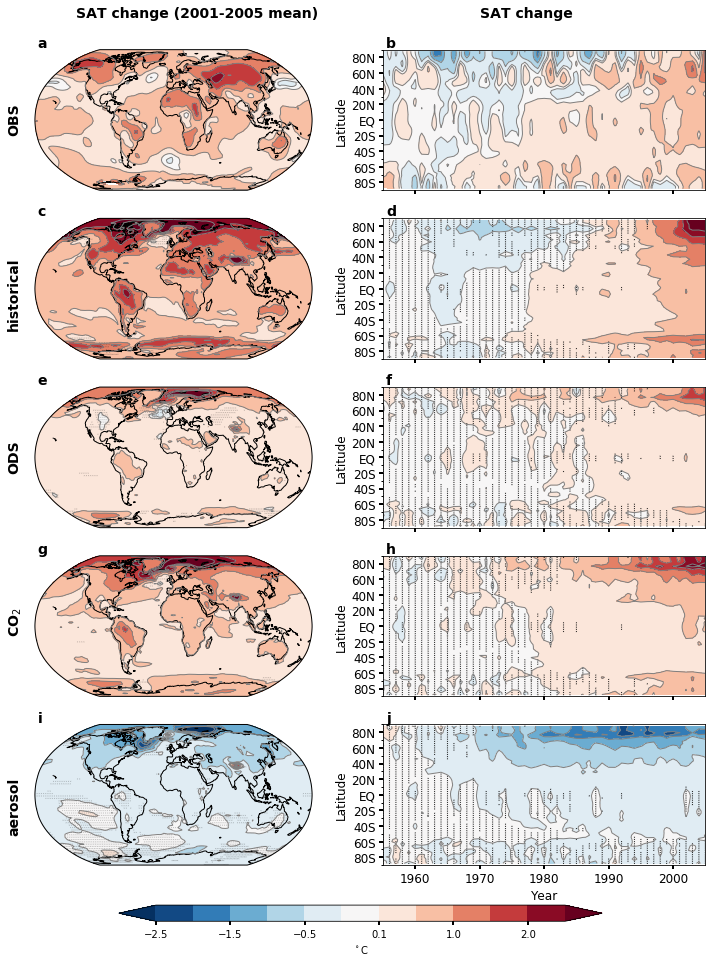

In [3]:

#==========================================================
#3. Plots  
#==========================================================
os.system('mkdir -p PLOTS')
##################settings
clevs=[-2.5,-2,-1.5,-1,-0.5,-0.1,0.1,0.5,1,1.5,2,2.5]
cf_params=dict(clevs=clevs,cmap='RdBu_r')
##################lonlat functions

def plot_lonlat(gs,x,title,label=None,obs=False):
    map_params=dict(region='glob_rob')
    cf_params['latlon']=True

    ax=rpl.make_ax_map(gs,**map_params);
    #cf
    if obs:
        cf=rpl.add_cf(ax,lon,lat,x,**cf_params)
    else:
        cf=rpl.add_cf(ax,lon,lat,np.mean(x,axis=0),**cf_params) 
        #sig
        sig=np.zeros([nlat,nlon])*np.nan
        sig[stats.ttest_1samp(x,0)[1]>0.05]=0.003
        lons,lats=np.meshgrid(lon,lat);
        ax.scatter(lons,lats,sig.squeeze(), facecolor='black',marker='x',transform=ccrs.PlateCarree())
    #title
    rpl.add_title(ax,title,label)
    return ax,cf



##################latyear functions

def myax_latyear(ax):
  ax.set_ylim(-90,90)
  ax.set_xlim(1955,2005)
  ax.yaxis.set_major_locator(MultipleLocator(20))
  ax.yaxis.set_minor_locator(MultipleLocator(10))    
  ax.yaxis.set_ticks_position('left')  
  ax.set_yticks(np.arange(-80,100,20))
  ax.set_yticklabels(('80S','60S','40S','20S','EQ', '20N', '40N', '60N','80N'))
  
def plot_latyear(gs,x,title,label=None,obs=False):
    cf_params['latlon']=False
    ax=plt.subplot(gs)
    #axes
    myax_latyear(ax); 
    if not ax.is_last_row(): ax.set_xticklabels((''))
    ax.set_ylabel('Latitude',fontsize='large')
    if obs:
        print (cf_params)
        cf=rpl.add_cf(ax,years,lat,np.transpose(x),**cf_params)            
    else:
        cf=rpl.add_cf(ax,years,lat,np.transpose(np.mean(x,axis=0)),**cf_params)  
        #sig
        sig=np.zeros([nyear,nlat])*np.nan
        sig[stats.ttest_1samp(x,0)[1]>0.05]=0.05
        lats,yearss=np.meshgrid(lat,years);
        ax.scatter(yearss,lats,sig, facecolor='black',marker='x')    
    #title
    rpl.add_title(ax,title,label)
    return ax,cf    



#==========================================================
#3a. ALL
#==========================================================
#import importlib; importlib.reload(rpl)
############### Setup fig
fig=plt.figure(figsize=(11,15))
gs = gridspec.GridSpec(nrows=5, ncols=2, right=1,
                        wspace=0.15,hspace=0.2)

############lonlat plots#######################
#OBS
ax,cf=plot_lonlat(gs[0,0],np.mean(tas_obs[-nyear_rm::,:,:],axis=0)-tas_obs_1950s,'','a',obs=True)
plt.text(-0.1,0.55,'OBS',fontsize=14,rotation=90,transform=ax.transAxes,fontweight='bold')
plt.text(0.15,1.23,'SAT change (2001-2005 mean)',fontsize=14,transform=ax.transAxes,fontweight='bold')
#hist
ax,cf=plot_lonlat(gs[1,0],np.mean(tas['historical'][:,-nyear_rm::,:,:],axis=1)-tas['historical'][:,0,:,:],'','c')
plt.text(-0.1,0.65,'historical',fontsize=14,rotation=90,transform=ax.transAxes,fontweight='bold')
#ODS
ax,cf=plot_lonlat(gs[2,0],np.mean(tas['historical'][:,-nyear_rm::,:,:],axis=1)-np.mean(tas['fixODS'][:,-nyear_rm::,:,:],axis=1),'','e')
plt.text(-0.1,0.55,'ODS',fontsize=14,rotation=90,transform=ax.transAxes,fontweight='bold')
#CO2
ax,cf=plot_lonlat(gs[3,0],np.mean(tas['historical'][:,-nyear_rm::,:,:],axis=1)-np.mean(tas['fixCO2'][:,-nyear_rm::,:,:],axis=1),'','g')
plt.text(-0.1,0.55,'CO$_2$',fontsize=14,rotation=90,transform=ax.transAxes,fontweight='bold')
#aer
ax,cf=plot_lonlat(gs[4,0],np.mean(tas['historical'][:,-nyear_rm::,:,:],axis=1)-np.mean(tas['fixaerosol'][:,-nyear_rm::,:,:],axis=1),'','i')
plt.text(-0.1,0.55,'aerosol',fontsize=14,rotation=90,transform=ax.transAxes,fontweight='bold')


############latyear plots#######################################
tas_zm_historical_cf1955=np.zeros((nens,nyear,nlat))*np.nan
for i in range(nens): tas_zm_historical_cf1955[i,:,:]=tas_zm['historical'][i,:,:]-tas_zm['historical'][i,0,:]

ax,cf=plot_latyear(gs[0,1],tas_zm_obs-tas_zm_obs_1950s,'','b',obs=True)
plt.text(0.3,1.23,'SAT change',fontsize=14,transform=ax.transAxes,fontweight='bold')

plot_latyear(gs[1,1],tas_zm_historical_cf1955,'','d')
plot_latyear(gs[2,1],tas_zm['historical']-tas_zm['fixODS'],'','f')
plot_latyear(gs[3,1],tas_zm['historical']-tas_zm['fixCO2'],'','h')
ax,cf=plot_latyear(gs[4,1],tas_zm['historical']-tas_zm['fixaerosol'],'','j')
ax.set_xlabel('Year',fontsize='large') 
rpl.add_cb(ax,cf,lscale=1.5,x0scale=0.1,y0scale=-5,orientation='horizontal',spacing='uniform',units='$^\circ$C')

rpl.mysavefig(fig,'PLOTS/tas_pattern_all.png')


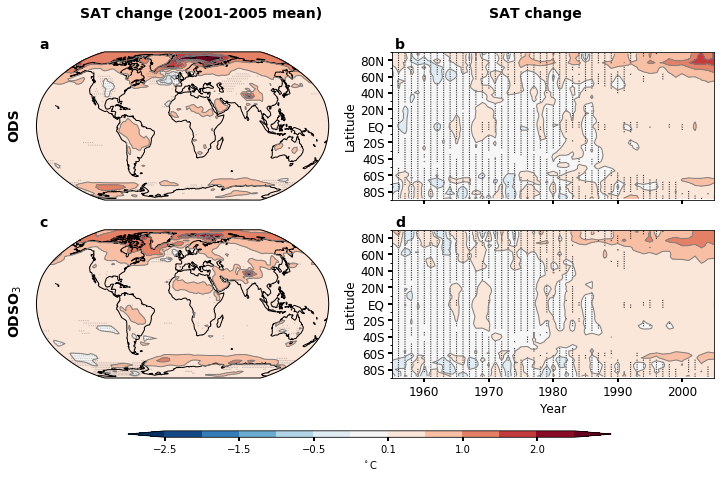

In [4]:


#==========================================================
#3b. ODS vs ODSO3
#==========================================================
############### Setup fig
fig=plt.figure(figsize=(11,6))
gs = gridspec.GridSpec(nrows=2, ncols=2, right=1,
                        wspace=0.15,hspace=0.2)

############lonlat plots#######################
#ODS
ax,cf=plot_lonlat(gs[0,0],np.mean(tas['historical'][:,-nyear_rm::,:,:],axis=1)-np.mean(tas['fixODS'][:,-nyear_rm::,:,:],axis=1),'','a')
plt.text(-0.1,0.55,'ODS',fontsize=14,rotation=90,transform=ax.transAxes,fontweight='bold')
plt.text(0.15,1.23,'SAT change (2001-2005 mean)',fontsize=14,transform=ax.transAxes,fontweight='bold')
#ODSO3
ax,cf=plot_lonlat(gs[1,0],np.mean(tas['historical'][:,-nyear_rm::,:,:],axis=1)-np.mean(tas['fixODSO3'][:,-nyear_rm::,:,:],axis=1),'','c')
plt.text(-0.1,0.55,'ODSO$_3$',fontsize=14,rotation=90,transform=ax.transAxes,fontweight='bold')


############latyear plots#######################################


#ODS
ax,cf=plot_latyear(gs[0,1],tas_zm['historical']-tas_zm['fixODS'],'','b')
plt.text(0.3,1.23,'SAT change',fontsize=14,transform=ax.transAxes,fontweight='bold')

#ODSO3
ax,cf=plot_latyear(gs[1,1],tas_zm['historical']-tas_zm['fixODSO3'],'','d')
ax.set_xlabel('Year',fontsize='large') 
rpl.add_cb(ax,cf,lscale=1.5,x0scale=0.1,y0scale=-5,orientation='horizontal',spacing='uniform',units='$^\circ$C')

rpl.mysavefig(fig,'PLOTS/tas_pattern_odsonly.png')




